In [1]:
library(tidyverse)
library(magrittr)
library(cowplot)
library(ggrepel)

fbrcaGenes <- c("ATM","BARD1","BLM","BRCA1","BRCA2","BRIP1","CDH1","CHEK2",
                "FAM175A","FANCC","FANCM","MLH1","MRE11","MSH2","NBN","NF1",
                "PALB2","PMS2","PTEN","RAD51B","RAD51C","RAD51D","RECQL",
                "RINT1","STK11","TP53")

gene2snp <- read_tsv("../../data/genesis/gene2snp.hg19", col_types = "cc") %>%
    set_colnames(c("snp", "gene"))
load("../../data/genesis/ld.RData")

highld <- filter(ld, r2 > 0.8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.3.4     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# BOOST

In [2]:
boost <- read_tsv("genesis.processed.boost.txt", 
                  col_types = "iccdddddddddd") %>%
    filter(! (paste(SNP1, SNP2, sep = "-") %in% highld$key | 
              paste(SNP2, SNP1, sep = "-") %in% highld$key)) %>%
    merge(gene2snp, by.y = "snp", by.x = "SNP1") %>%
    merge(gene2snp, by.y = "snp", by.x = "SNP2") %>%
    arrange(-InteractionBOOST, -InteractionPLINK) 

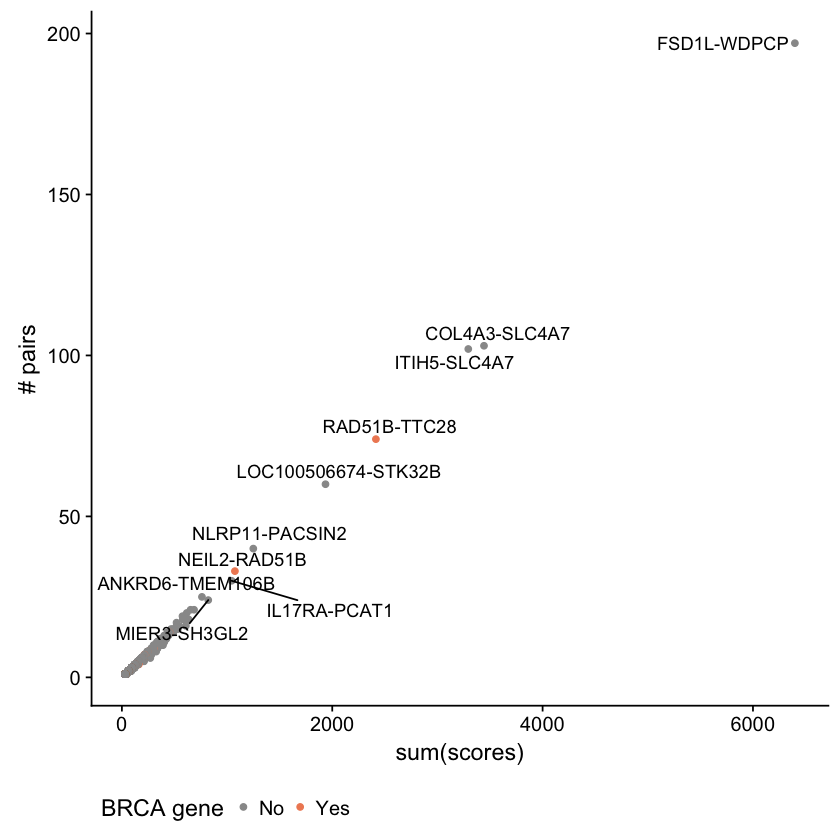

In [3]:
boostTop <- boost %>%
    mutate(gene1 = ifelse(gene.x < gene.y, gene.x, gene.y),
           gene2 = ifelse(gene.x < gene.y, gene.y, gene.x),
           brcaGene = ifelse(gene1 %in% fbrcaGenes | gene2 %in% fbrcaGenes, "Yes", "No")) %>%
    unite(genepair, gene1, gene2, sep = "-") %>%
    group_by(genepair, brcaGene) %>%
    summarize(score = sum(InteractionBOOST),
              n = n()) %>%
    arrange(-score)

ggplot() +
    geom_point(data = boostTop, aes(x = score, y = n, color = brcaGene)) +
    geom_text_repel(data = head(boostTop, 10), 
                     aes(x = score, y = n, label = genepair)) +
    scale_colour_manual(values = c("Yes" = "#ef8a62", "No" = "#999999")) +
    labs(x = "sum(scores)", y = "# pairs", color = "BRCA gene") +
    theme(legend.position="bottom")

# MBMDR

In [4]:
mbmdr <- read_table("genesis.mbmdr_output.txt", col_types = "ccdd", skip = 2) %>%
    set_colnames(c("snp1", "snp2", "chi2", "p"))

In [5]:
mbmdr %>%
    filter(p < 0.05) %>% 
    merge(gene2snp, by.y = "snp", by.x = "snp1", all.x = T) %>%
    merge(gene2snp, by.y = "snp", by.x = "snp2", all.x = T, suffixes = c("1","2")) %>%
    select(gene1, gene2) %>%
    unique

gene1,gene2
DPP10,NA
